In [ ]:
# global configuration variables
dbFilename = r"nature-sounds-1.db"

# source folder for archive files
siblingSourceFolder = "corpus"

In [ ]:
import essentia
from essentia import Pool, array
import essentia.streaming as ess
import essentia.standard as stan
from pylab import *
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Audio

## SQLite interface

In [12]:
import sqlite3
from sqlite3 import Error


def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
#     try:
    conn = sqlite3.connect(db_file)
    print(sqlite3.version)
    return conn
#     except Error as e:
#         print(e)
        
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def create_memo(conn, memo):
    """
    Create a new memo into the memos table
    :param conn:
    :param memo:
    :return: project id
    """
    sql = ''' INSERT INTO memos(name)
              VALUES(?) '''
    cur = conn.cursor()
    cur.execute(sql, memo)
    conn.commit()
    return cur.lastrowid

def create_note(conn, note):
    """
    Create a new note
    :param conn:
    :param note:
    :return: note id
    """

    sql = ''' INSERT INTO notes(durationSeconds,effectiveDuration,rms,loudness,pitch,pitchConfidence,flatness,centroid,variance,path,memo_id,start,end)
              VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, note)
    conn.commit()

    return cur.lastrowid

def create_descriptor_stats(conn, stats):
    """
    Create a new task
    :param conn:
    :param stats:
    :return: stats id
    """

    sql = ''' INSERT INTO stats(descriptor, avg, stddev, min, max)
              VALUES(?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, stats)
    conn.commit()

    return cur.lastrowid

def update_stats(conn, stats):
    sql = ''' UPDATE stats
              SET descriptor = ?
              WHERE id = ?'''
    cur = conn.cursor()
    cur.execute(sql, stats)
    conn.commit()

def delete_stats(conn):
    """
    Delete stats records
    :param conn:
    """

    sql = ''' DELETE FROM stats '''
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()

## SQLite user-defined functions

In [13]:
import sqlite3
import math

def create_stats(descriptorName,avg,stddev,descriptorMin,descriptorMax):
    statsRecord = (
        descriptorName,
        avg,
        stddev,
        descriptorMin,
        descriptorMax
    )
    return create_descriptor_stats(db, statsRecord)

# https://www.alexforencich.com/wiki/en/scripts/python/stdev
class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1
 
    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1
 
    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))
    
class HistogramFunc:
    def __init__(self):
        self.d = np.empty(1)

    def step(self, value):
        self.d = np.append(self.d, value)
 
    def finalize(self):
        self.d = np.delete(self.d, 0)
        
        stddev = np.std(self.d)
        mean = np.mean(self.d)
        descMin = np.amin(self.d)
        descMax = np.amax(self.d)

        print("mean, std")
        print(mean)
        print(stddev)
        
        print("min")
        print(descMin)
        print(np.argmin(self.d))

        
        print("max")
        print(descMax)
        print(np.argmax(self.d))

        range_low = mean - 2*stddev;
        range_high = mean + 2*stddev;
        if range_low < 0:
            range_low = 0
        range_tuple = (range_low,range_high)
        print(range_tuple)

        plt.hist(self.d, bins = 40, range = range_tuple) 
        plt.title("Histogram") 
        plt.show()
        
        stats_id = create_stats("name", mean, stddev, descMin, descMax)
        
        return stats_id


## Create database and tables

In [14]:
db = create_connection(dbFilename)

sql_create_stats_table = """ CREATE TABLE stats (
                                    id integer PRIMARY KEY,
                                    descriptor text NOT NULL,
                                    avg float NOT NULL,
                                    stddev float NOT NULL,
                                    min float NOT NULL,
                                    max float NOT NULL
                                ); """

sql_create_memos_table = """ CREATE TABLE memos (
                                    id integer PRIMARY KEY,
                                    name text NOT NULL
                                ); """

sql_create_notes_table = """CREATE TABLE notes (
                                    id integer PRIMARY KEY,
                                    durationSeconds float NOT NULL,
                                    effectiveDuration float NOT NULL,
                                    rms float NOT NULL,
                                    loudness float NOT NULL,
                                    pitch float NOT NULL,
                                    pitchConfidence float NOT NULL,
                                    flatness float NOT NULL,
                                    centroid float NOT NULL,
                                    variance float NOT NULL,
                                    path text NOT NULL,
                                    memo_id integer NOT NULL,
                                    start integer NOT NULL,
                                    end integer NOT NULL,
                                    FOREIGN KEY (memo_id) REFERENCES memos (id)
                                );"""

# create tables
if db is not None:
    # create stats table
    create_table(db, sql_create_stats_table)
    
    # create memos table
    create_table(db, sql_create_memos_table)

    # create notes table
    create_table(db, sql_create_notes_table)
else:
    print("Error! cannot create the database connection.")

2.6.0
table stats already exists
table memos already exists
table notes already exists


In [15]:
def get_notes_from_onsets(onset_positions, audio):

    notes = []
    skipped = 0
    numOnsets = onset_positions.shape[0]
    if numOnsets == 1:
        return notes;
    for i in range(numOnsets):
        if i == 0:
            continue

        nStart = int(sampleRate * onset_positions[i-1]) # previous onset sample
        nEnd = int(sampleRate * onset_positions[i]) # current onset sample

        if(nEnd-nStart) < sampleRate*0.15: # remove sounds that are shorter than 0.15 seconds
            continue
        if(nEnd-nStart) > sampleRate*10: # filter sounds that are longer than 10
            continue

        startFrame = int(nStart/hopSize) # loss of precision here
        endFrame = int(nEnd/hopSize)

        noteData = {}
        noteData["rms"] = stan.Mean()(pool["features.rms"][startFrame:endFrame])
        
        noteData["loudness"] = stan.Mean()(pool["features.loudness"][startFrame:endFrame])

        #print("mean rms: " + str(stan.Mean()(pool["features.rms"][startFrame:endFrame])))
        #print("weighted rms: " + str(noteData["rms"]))
             
        noteData["flatness"] = energy_weighted_mean(pool["features.flatnessDB"], startFrame, endFrame)
        
        weighted_mean_centroid = energy_weighted_mean(pool["features.centroid"], startFrame, endFrame)
        centroid_frequency = weighted_mean_centroid * (sampleRate/2)
        centroid_mel = 1000 * math.log2(1 + centroid_frequency/1000)
        noteData["centroid"] = centroid_mel
        
        noteData["variance"] = energy_weighted_mean(pool["features.variance"], startFrame, endFrame)

        pitch_freq = pitch_confidence_weighted_mean(pool["features.pitch"], startFrame, endFrame)
        if pitch_freq < 1:
            pitch_freq = 0
        noteData["pitch"] = 1000 * math.log2(1 + pitch_freq/1000)
        #print("mean pitch: " + str(stan.Mean()(pool["features.pitch"][startFrame:endFrame])))
        #print("weighted pitch: " + str(noteData["pitch"]))
        
        noteData["pitchConfidence"] = energy_weighted_mean(pool["features.pitchConfidence"], startFrame, endFrame)
        
        noteData["audio"] = audio[nStart:nEnd]
        noteData["start"] = nStart
        noteData["end"] = nEnd
        
        if(nStart > len(audio)):
            skipped = skipped + 1
            continue

        notes.append(noteData)

    return notes

def energy_weighted_mean(feature_vector, startFrame, endFrame):
    weights = pool["features.energy"][startFrame : endFrame]
    weighted_feature = feature_vector[startFrame : endFrame] * weights
    weighted_feature_sum = np.sum(weighted_feature)
    
    return float(weighted_feature_sum / np.sum(weights))

def pitch_confidence_weighted_mean(feature_vector, startFrame, endFrame):
    weights = pool["features.pitchConfidence"][startFrame : endFrame]
    weighted_feature = feature_vector[startFrame : endFrame] * weights
    weighted_feature_sum = np.sum(weighted_feature)
    
    return float(weighted_feature_sum / np.sum(weights))
    

In [16]:
# putting it all together
from pathlib import Path
from scipy.io.wavfile import write, read
import json

def write_memo_notes_to_db(memoFile, notes):
    # initialize an object to store data for the clip
    memo = (memoFile,)
    memo_id = create_memo(db, memo)

    # process each detected note
    for i, note in enumerate(notes):
        sourcePath = Path(f"{siblingSourceFolder}/{memoFile}")
        durationSeconds = len(note["audio"]) / sampleRate
        
        effectiveDuration = stan.EffectiveDuration()(note["audio"])
        
        noteRecord = (
            durationSeconds,
            effectiveDuration,
            note["rms"],
            note["loudness"],
            note["pitch"],
            note["pitchConfidence"],
            note["flatness"],
            note["centroid"],
            note["variance"],
            str("/".join(sourcePath.parts)),
            memo_id,
            note["start"],
            note["end"]
        )

        create_note(db, noteRecord)

In [17]:
def already_processed(memoFile):
    cursor = db.cursor()
    rowsQuery = "SELECT Count(*) FROM memos where name = '" + memoFile + "';"
    cursor.execute(rowsQuery)
    return cursor.fetchone()[0] > 0

In [18]:
from datetime import datetime
import os
print("Loading extractor...")

count = 1;

standardLoader = stan.MonoLoader()
streamingLoader = ess.MonoLoader()

sampleRate=44100
frameSize=2048
hopSize=512

framecutter = ess.FrameCutter(frameSize=frameSize, hopSize=hopSize, silentFrames='noise')
windowing = ess.Windowing(type='hann')
c2p = ess.CartesianToPolar()
od1 = ess.OnsetDetection(method='hfc')
fft = ess.FFT()
pitch = ess.PitchYinFFT(frameSize=frameSize)
rms = ess.RMS()
loudness = ess.Loudness()
flatness = ess.FlatnessDB()
centroid = ess.Centroid()
variance = ess.Variance()
spectrum = ess.Spectrum()
energy = ess.Energy()
pool = Pool()

# Connect streaming algorithms
streamingLoader.audio >> framecutter.signal
framecutter.frame >> windowing.frame >> fft.frame
fft.fft >> c2p.complex
c2p.phase >> od1.phase
c2p.magnitude >> None

windowing.frame >> energy.array
energy.energy >> (pool, 'features.energy')

windowing.frame >> spectrum.frame
spectrum.spectrum >> od1.spectrum
od1.onsetDetection >> (pool, 'features.hfc')

windowing.frame >> rms.array
rms.rms >> (pool, 'features.rms')

windowing.frame >> loudness.signal
loudness.loudness >> (pool, 'features.loudness')

spectrum.spectrum >> pitch.spectrum
pitch.pitch >> (pool, 'features.pitch')
pitch.pitchConfidence >> (pool, 'features.pitchConfidence')

c2p.magnitude >> flatness.array
flatness.flatnessDB >> (pool, 'features.flatnessDB')

c2p.magnitude >> centroid.array
centroid.centroid >> (pool, 'features.centroid')

c2p.magnitude >> variance.array
variance.variance >> (pool, 'features.variance')

for memoFile in os.listdir(os.getcwd() + "/" + siblingSourceFolder):
    if (memoFile.endswith(".wav") or memoFile.endswith(".m4a") or memoFile.endswith(".aiff") or memoFile.endswith(".mp3")):
        if already_processed(memoFile):
            print("skipping, we already processed: " + memoFile)
            continue
        standardLoader.configure(filename=siblingSourceFolder + "/" + memoFile)
        audio = standardLoader()
        streamingLoader.configure(filename=siblingSourceFolder + "/" + memoFile)
        
        essentia.run(streamingLoader)

        # Phase 2: compute the actual onsets locations
        
        # NOTE This implementation depends on a frameRate of 44100.0/512.0
        onsets = stan.Onsets(frameRate=sampleRate/hopSize)

        onsets_hfc = onsets(# this algo expects a matrix, not a vector
            array([ pool['features.hfc'] ]),
            # you need to specify weights, but as there is only a single
            # function, it doesn't actually matter which weight you give it
            [ 1 ])
        
        notes = get_notes_from_onsets(onsets_hfc, audio)
        write_memo_notes_to_db(memoFile, notes)
        
        print('✅ ' + memoFile + " : " + str(len(notes)) + " sound objects"

        count = count + 1
        # clear pool for next run
        pool.clear()



Loading extractor...
skipping, we already processed: Tapestries_01_wilderness-01.wav
skipping, we already processed: Tapestries_01_wilderness-02.wav
skipping, we already processed: Tapestries_01_wilderness-03.wav
skipping, we already processed: Tapestries_01_wilderness-04.wav
skipping, we already processed: Tapestries_01_wilderness-05.wav
skipping, we already processed: Tapestries_01_wilderness-06.wav
skipping, we already processed: Tapestries_01_wilderness-07.wav
skipping, we already processed: Tapestries_01_wilderness-08.wav
skipping, we already processed: Tapestries_01_wilderness-09.wav
skipping, we already processed: Tapestries_01_wilderness-10.wav
✅ Tapestries_01_wilderness-11.wav : 560 sound objects : 1 processed
✅ Tapestries_01_wilderness-12.wav : 384 sound objects : 2 processed
✅ Tapestries_01_wilderness-13.wav : 573 sound objects : 3 processed
✅ Tapestries_01_wilderness-14.wav : 385 sound objects : 4 processed
✅ Tapestries_01_wilderness-15.wav : 297 sound objects : 5 processed

2.6.0
📊 durationSeconds 📈
(21304,)
0.540392141022
0.822097568631
min
0.150907029478
152
max
9.70594104308
9649
(0, 2.1845872782842739)


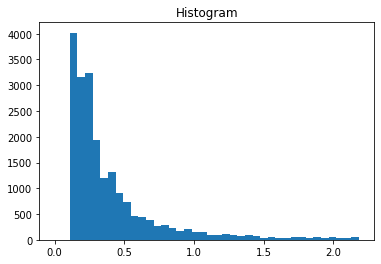

📊 rms 📈
(21304,)
2.47388644175e-05
2.88831071379e-05
min
1.75562135496e-07
8224
max
0.000337670615409
8905
(0, 8.2505078693325074e-05)


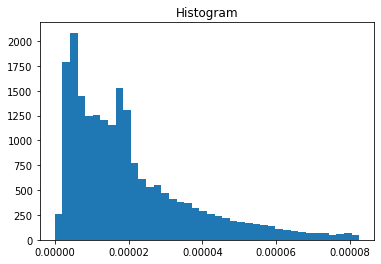

📊 loudness 📈
(21304,)
0.000146446767685
0.000263006988476
min
1.56386974481e-07
8224
max
0.00377288064919
8905
(0, 0.00067246074463738013)


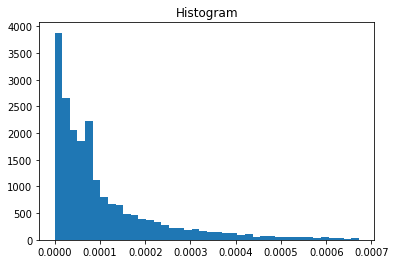

📊 pitch 📈
(21304,)
1346.03410656
580.680492002
min
135.171591659
9229
max
3683.23479347
16480
(184.67312255581851, 2507.3950905646252)


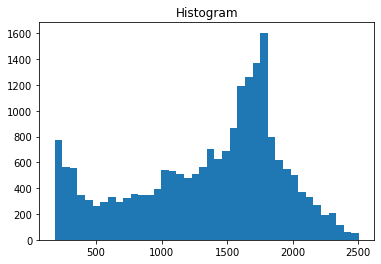

📊 flatness 📈
(21304,)
0.124481528883
0.0641289616267
min
0.0204814858735
11376
max
0.336845189333
21056
(0, 0.25273945213639182)


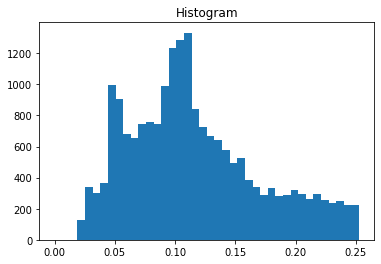

📊 centroid 📈
(21304,)
2278.95007555
556.794583599
min
521.455340937
8664
max
3454.39742675
8224
(1165.3609083505885, 3392.539242745675)


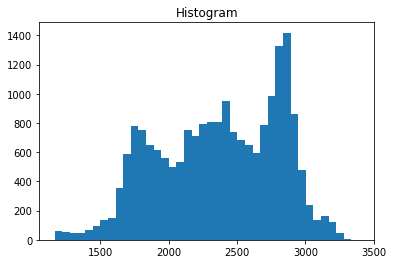

📊 variance 📈
(21304,)
8.91873416251e-06
2.80970704402e-05
min
2.26138469062e-10
8224
max
0.000633967050817
8708
(0, 6.5112875042928344e-05)


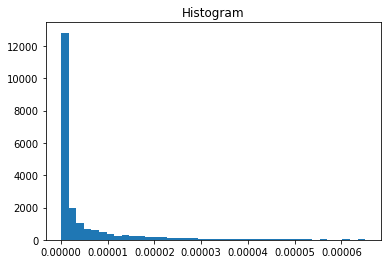

In [20]:
db = create_connection(dbFilename)
db.create_aggregate("stdev", 1, StdevFunc)
db.create_aggregate("histogram", 1, HistogramFunc)

 
def stats(column_name, conn):
    print("📊 %s 📈" % column_name)
    cur = db.cursor()
    cur.execute("select histogram(%s) from notes" %column_name)
    stats_id = cur.fetchone()[0]
    stats_record = (column_name, stats_id)
    update_stats(conn, stats_record)
    
    
delete_stats(db)

stats("durationSeconds", db)
stats("effectiveDuration", db)
stats("rms", db)
stats("loudness", db)
stats("pitch", db)
stats("flatness", db)
stats("centroid", db)
stats("variance", db)
